# Cyclist - Density Based Clustering (DBSCAN)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.cluster.hierarchy import fcluster

from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

!!! IMPORTANT !!!

This notebook, along with the notebooks ‘cyclist_density_based_clustering_3f.ipynb’ and ‘cyclist_density_based_clustering_5f.ipynb’ study the application of the DBSCAN density-based clustering algorithm. In particular, they represent three variants of our approach, aimed at studying the inclusion of more or fewer features in the clustering process.

The variant approach below includes in the clustering process the 5 features 'mean_bmi', 'mean_cp' (climb power), 'mean_position' and 'mean_delta'.

The selection of these features was derived from a data understanding process, applied following the data cleaning and feature engeneering phases, through which it was possible to skim the attributes by identifying those that appeared to be the most significant.It is also important to note that this notebook utilises fewer features than the previous variant '‘cyclist_density_based_clustering_5f.ipynb’, and the eliminated features were selected due to a perceived lack of affinity to the clustering of the data studied.

In [3]:
dataset = pd.read_csv('../../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')

In [ ]:
'''
Clustering Features Cyclists:
-'cyclist_bmi', 
-'cyclist_climb_power', 
-'position', 
-'delta'
'''

"\nClustering Features Cyclists:\n-'cyclist_bmi', \n-'cyclist_age', \n-'height', \n-'cyclist_climb_power', \n-'position', \n-'delta'\n"

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589739 entries, 0 to 589738
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   cyclist_url                   589739 non-null  object        
 1   cyclist_name                  589739 non-null  object        
 2   birth_year                    589739 non-null  int64         
 3   weight                        480007 non-null  float64       
 4   height                        480007 non-null  float64       
 5   nationality                   589739 non-null  object        
 6   race_url                      589739 non-null  object        
 7   race_name                     589739 non-null  object        
 8   points                        589739 non-null  float64       
 9   uci_points                    422184 non-null  float64       
 10  length                        589739 non-null  float64       
 11  climb_total  

In [6]:
columns_to_use = ['mean_cp', 'mean_position', 'mean_delta', 'mean_bmi'] # we need to accumulate the features values in the dataset, so to have only one per cyclist

# the cyclist_climb_power attribute is instead accumulated respect to a weighted mean based on the climb_percentage of each record (we need to give less weight to less steep profiles)
weighted_mean_cp = (
    dataset.groupby('cyclist_url').apply(
        lambda group: (group['cyclist_climb_power'] * group['climb_percentage']).sum() / group['climb_percentage'].sum()
    )
)

# the delta attribute is accumulated with a weighted mean based on the number of records (we dont want more representeed cyclists to be penalized)
group_sizes = dataset.groupby('cyclist_url').size()
dataset['group_size'] = dataset['cyclist_url'].map(group_sizes)
weighted_mean_delta = (
    dataset.groupby('cyclist_url').apply(
        lambda group: (group['delta'] * group['group_size']).sum() / group['group_size'].sum()
    )
)

# the position attribute is accumulated with a weighted mean based on the number of records (we dont want more representeed cyclists to be penalized)
weighted_mean_pos = (
    dataset.groupby('cyclist_url').apply(
        lambda group: (group['position'] * group['group_size']).sum() / group['group_size'].sum()
    )
)

# we map the means calculated back to each row
mean_bmi = dataset.groupby('cyclist_url')['cyclist_bmi'].mean() # fixed
dataset['mean_bmi'] = dataset['cyclist_url'].map(mean_bmi)
dataset['mean_delta'] = dataset['cyclist_url'].map(weighted_mean_delta)
dataset['mean_position'] = dataset['cyclist_url'].map(weighted_mean_pos)
dataset['mean_cp'] = dataset['cyclist_url'].map(weighted_mean_cp)


dataset = dataset[['cyclist_url', 'mean_cp', 'mean_position', 'mean_delta', 'mean_bmi']].drop_duplicates()
dataset = dataset[columns_to_use]


/tmp/ipykernel_47291/2118684062.py:6: RuntimeWarning: invalid value encountered in scalar divide
  lambda group: (group['cyclist_climb_power'] * group['climb_percentage']).sum() / group['climb_percentage'].sum()
/tmp/ipykernel_47291/2118684062.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset.groupby('cyclist_url').apply(
/tmp/ipykernel_47291/2118684062.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this wa

In [7]:
weighted_mean_cp

cyclist_url
aad-van-den-hoek      0.000932
aaron-gate            0.002571
aaron-kemps           0.004649
aaron-olsen           0.000000
aaron-van-poucke      0.000047
                        ...   
zenon-jaskula         0.003164
zhandos-bizhigitov    0.000055
zico-waeytens         0.001403
zoran-klemencic       0.001654
zsolt-der             0.000000
Length: 6095, dtype: float64

In [8]:
data_for_clustering = dataset.dropna() #TODO: remove when we have imputed the missing values

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

Thanks to the following model selection process, the two parameters of the ‘DBSCAN’ algorithm (‘eps’ and ‘min_samples’) were selected in the context of this case study. Of the options studied in the process, the evaluation was made according to the trade-off between the number of clusters identified and silhouette score.

Each iteration of the model selection process starts with setting the ‘min_points’ parameter, studied in the range 2-20. For each of these alternatives, the optimal value of the ‘eps’ parameter is identified through the identification of the knee-point in the curve defined by the points (k-th distance, index).

Our Knee Method implementation:

- We compute the 𝑘-distance for each point:
    - Choose a value for 𝑘, a tipical choice should be to set to 𝑘 = min_points − 1, where min_points is the minimum number of points required to form a dense region (DBSCAN parameter fixed in the model selection iteration). 
    - For each point in the dataset, we calculate the distance to its 𝑘-th nearest neighbor (𝑘-distance).
- We sort the 𝑘-distances:
    - Arrange all the points by their 𝑘-distance in a 𝑘-distance plot, where the x-axis is the points (sorted) and the y-axis is their 𝑘-distance.
- Plot the 𝑘-distance graph
- Identify the "knee" in the plot: The y-axis typically increases gradually at first and then sharply increases, forming a curve. The knee corresponds to the point of maximum curvature in the graph. It is the location where the slope changes most significantly. Intuitively, it separates the "dense" regions (gradual slope) from the "sparse" regions (steep slope) in the dataset.


To automate the process of knee detection, we relied on the kneed library (KneeLocator).


#### Model Selection

In [ ]:
dist = squareform(pdist(data_scaled, 'euclidean'))
min_points = range(2, 20)
optimal_eps = []
optimal_index = []
cluster_count = []
silhouette_scores = []



for i, value in enumerate(min_points):
    k = value - 1 #standard value? TODO: check this
    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    sorted_distances = sorted(kth_distances)
    indices = range(0, len(kth_distances))

    # Use the KneeLocator to find the knee point
    kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")
    
    if(kneedle.knee is None):
        optimal_eps.append(None) 
        optimal_index.append(None)  
        silhouette_scores.append(None)
        continue
    
    # Get the knee (selecting automatically the optimal epsilon)
    optimal_eps.append(sorted_distances[kneedle.knee])  # The y-value at the knee
    optimal_index.append(kneedle.knee)  # The x-value (index)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=optimal_eps[i], min_samples=value)
    clusters = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the data
    data_for_clustering['cluster'] = clusters
    number_of_clusters = data_for_clustering['cluster'].nunique()
    cluster_count.append(number_of_clusters)
    
    if(number_of_clusters < 3): # Considering that a cluster (label -1) is that of outliers, to compute silhouette we need at least 3 clusters here
        silhouette_scores.append(None)
        continue
    
    # Removing outliers so to not include them in silhouette calculation
    no_out_data_scaled = scaler.fit_transform(data_for_clustering[data_for_clustering['cluster'] != -1])
    no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

    # Calculate Silhouette
    silhouette_scores.append(silhouette_score(no_out_data_scaled, no_out_labels))
    

# Creating the DataFrame
model_selection_data = {"min_points": min_points, "optimal_eps": optimal_eps, "optimal_index": optimal_index, "cluster_count": cluster_count, "silhouette_score": silhouette_scores}
model_selection_df = pd.DataFrame(model_selection_data)

model_selection_df

/tmp/ipykernel_47291/780605452.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters
/tmp/ipykernel_47291/780605452.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters
/tmp/ipykernel_47291/780605452.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,min_points,optimal_eps,optimal_index,cluster_count,silhouette_score
0,2,1.012570,3019,8,0.551169
1,3,1.629536,3036,3,0.912455
2,4,2.761518,3050,2,NaN
3,5,1.451271,3016,4,0.845790
4,6,2.237924,3040,2,NaN
5,7,1.668816,3018,2,NaN
6,8,1.731029,3017,2,NaN
7,9,1.234640,2979,2,NaN
8,10,2.030895,3024,2,NaN
9,11,2.421920,3032,2,NaN


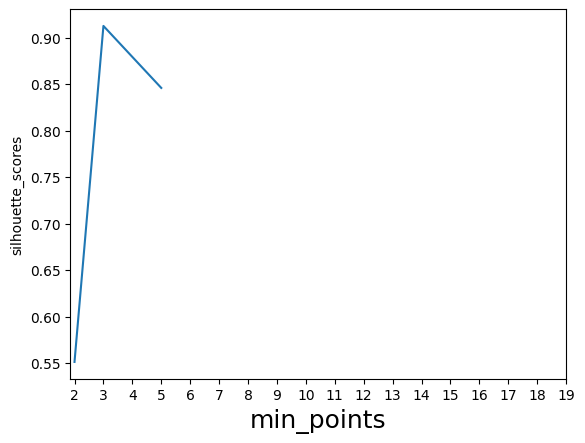

In [10]:
x = model_selection_df[model_selection_df['cluster_count'] > 2]['min_points']
y = model_selection_df[model_selection_df['cluster_count'] > 2]['silhouette_score']

plt.plot(x, y)
plt.ylabel('silhouette_scores')
plt.xlabel('min_points', fontsize=18)
plt.xticks(min_points)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### Chosen Parameter Clustering

(4680270,)
(3060, 3060)
Optimal epsilon (eps): 1.4512709283108918
Knee point index: 3016


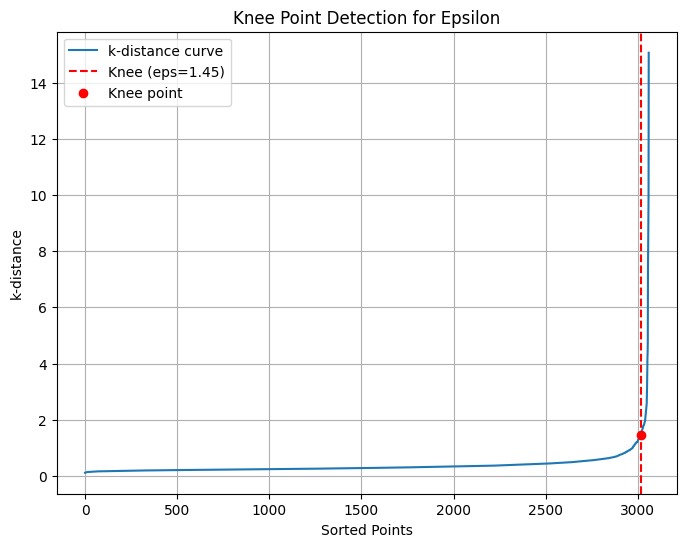

In [11]:
min_points = 5 # found throught model selection

dist = pdist(data_scaled, 'euclidean') #pair wise distance
print (dist.shape)
dist = squareform(dist) #distance matrix given the vector dist
print(dist.shape)

k = min_points - 1 #standard value?
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

sorted_distances = sorted(kth_distances)
indices = range(0, len(kth_distances))

# Use the KneeLocator to find the knee point
kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

# Get the knee (optimal epsilon)
optimal_eps = sorted_distances[kneedle.knee]  # The y-value at the knee
optimal_index = kneedle.knee  # The x-value (index)

print(f"Optimal epsilon (eps): {optimal_eps}")
print(f"Knee point index: {optimal_index}")

# Plot the k-distance graph with the knee point marked
plt.figure(figsize=(8, 6))
plt.plot(indices, sorted_distances, label="k-distance curve")
plt.axvline(optimal_index, linestyle="--", color="r", label=f"Knee (eps={optimal_eps:.2f})")
plt.scatter(optimal_index, optimal_eps, color="red", label="Knee point", zorder=5)
plt.xlabel("Sorted Points")
plt.ylabel("k-distance")
plt.title("Knee Point Detection for Epsilon")
plt.legend()
plt.grid()
plt.show()

#### Selection of best eps

In [12]:
# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_points)
clusters = dbscan.fit_predict(data_scaled)

# Add cluster labels to the data
data_for_clustering['cluster'] = clusters

# Display cluster distribution
print(data_for_clustering['cluster'].value_counts())
print(data_for_clustering.head())

cluster
 0    3020
-1      25
 2      10
 1       5
Name: count, dtype: int64
      mean_cp  mean_position  mean_delta   mean_bmi  cluster
0    0.000932       0.707648  398.568966  22.256908        0
58   0.002571       0.620541  847.935484  21.672110        0
89   0.004649       0.467297  404.819672  22.282592        0
196  0.000047       0.666310  458.285714  21.705129        0
203  0.000032       0.828177  559.000000  20.756387        0


/tmp/ipykernel_47291/4157897731.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters


In [13]:
np.unique(dbscan.labels_, return_counts=True)


(array([-1,  0,  1,  2]), array([  25, 3020,    5,   10]))

In [14]:
# Identify outliers (cluster label -1)
outliers = data_for_clustering[data_for_clustering['cluster'] == -1]
print("\nNumber of outliers:", len(outliers))


Number of outliers: 25


In [15]:
# Analyze the mean and standard deviation of numerical features for each cluster
cluster_stats = data_for_clustering.groupby('cluster').agg(['mean', 'std'])
print("Cluster Statistics:\n", cluster_stats)

Cluster Statistics:
           mean_cp           mean_position             mean_delta               \
             mean       std          mean       std         mean          std   
cluster                                                                         
-1       0.023941  0.030915      0.656639  0.222391  1746.975702  1805.364110   
 0       0.002372  0.002637      0.577661  0.156466   514.666299   227.414882   
 1       0.049840  0.003301      0.579274  0.070041   462.017311    89.600034   
 2       0.028866  0.002230      0.443107  0.167799   415.748868   233.289991   

          mean_bmi            
              mean       std  
cluster                       
-1       21.601838  1.993432  
 0       21.190426  1.343971  
 1       20.879350  0.805035  
 2       20.671719  0.913704  


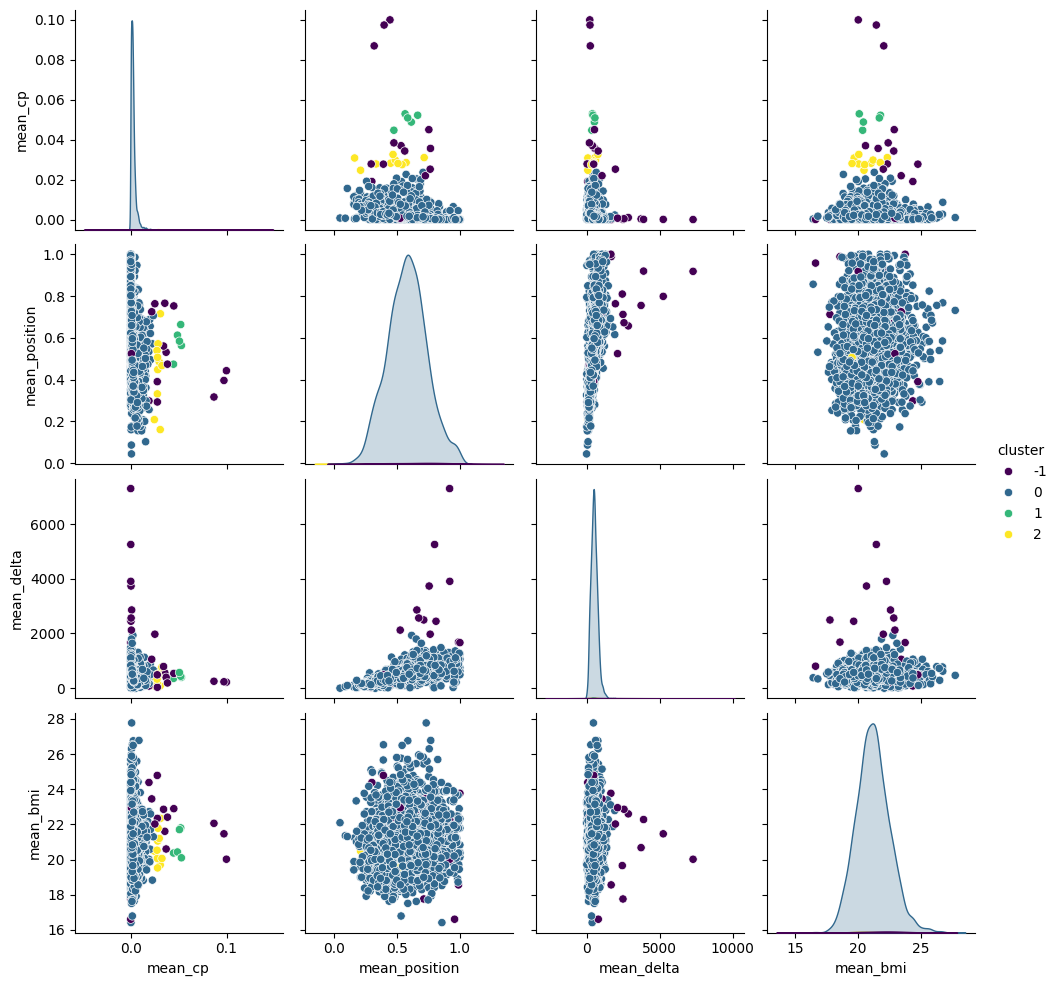

In [16]:

# Pair plot for a subset of columns
data_subset = data_for_clustering[columns_to_use + ["cluster"]]
sns.pairplot(data_subset, hue='cluster', palette='viridis')
plt.show()

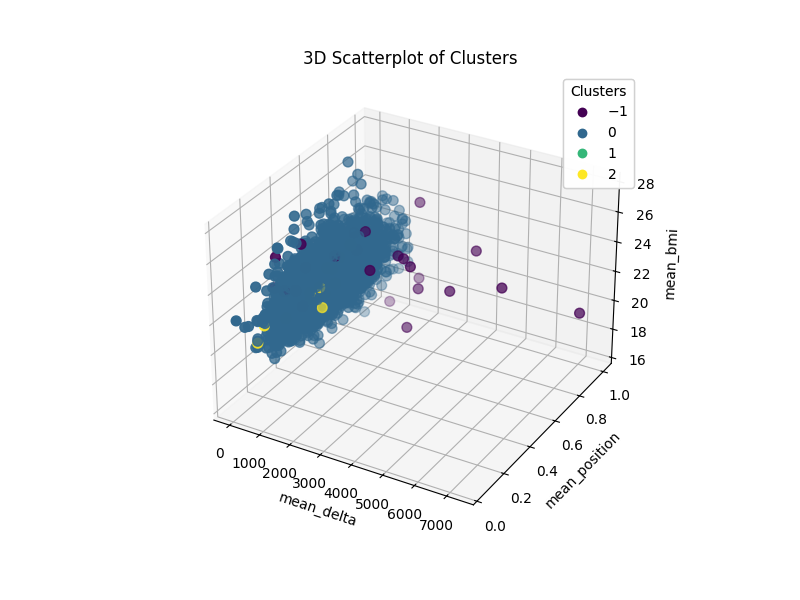

In [19]:
%matplotlib widget

x = data_for_clustering['mean_delta']  # Prima feature
y = data_for_clustering['mean_position']  # Seconda feature
z = data_for_clustering['mean_bmi']  # Terza feature

# Crea il grafico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot
scatter = ax.scatter(x, y, z, c=data_for_clustering['cluster'], cmap='viridis', s=50)
ax.set_xlabel('mean_delta')
ax.set_ylabel('mean_position')
ax.set_zlabel('mean_bmi')

# Aggiungi una legenda (opzionale)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title('3D Scatterplot of Clusters')

# Abilita la modalità interattiva
plt.ion()
plt.show()

Analyzing the clustering that excluded the "height" feature, we can observe how three clusters have been highlighted in the data.

The clusters can be analysed as follows (colour references and labels in the plots):
- yellow (2) : cyclists with a "mean_climb_power" value above the average. This cluster may represent cyclists who perform better than most of their peers. However, it is not the best performing cluster in terms of "mean_climb_power".
- green (1): cyclists with a "mean_climb_power" value highly above the average. This cluster may represent cyclists who perform better than the great majority of their peers.
- dark blue (-1): outliers
- blue (0): avarage performative cyclists

No relevant associations seem to emerge between the clusters identified by the algorithm and the other features, in particular respect to the feature "cyclist_bmi", so we proceed with the analyses of the notebook "cyclist_density_based_clustering_3f", where we reduce the features to those that from these results seem to be more influential in a possible clustering (observing the distribution of the data in space). We then eliminate the feature "cyclist_bmi".

In [18]:
data_scaled = scaler.fit_transform(data_for_clustering[data_for_clustering['cluster'] != -1])
no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

print('Silhouette %s' % silhouette_score(data_scaled, no_out_labels))

Silhouette 0.8457897095244079
